# Ordinary Kriging

In [63]:
import pandas as PD
import geopandas as GPD
import numpy as NP
import matplotlib.pyplot as PLT
import scipy.linalg
from scipy import optimize as OPT
from tqdm import tqdm as TQDM
from scipy.spatial import cKDTree
from scipy.spatial.distance import cdist
from scipy.optimize import least_squares
from variogram import variogram as VARIOGRAM

## Data 1

In [2]:
def variogram_spherical(d, pars):
    """Spherical model, pars[3] = [psill, range, nugget]
                             3 * d           d^3  
    x <= [2] : y = [0] * ( ---------  -  ---------- ) + [2]
                            2 * [1]       2 * [1]^3
    x > [2]  : y = [0] + [2]
    """
    psill = float(pars[0])
    prange = float(pars[1])
    pnugget = float(pars[2])
    return NP.piecewise( d, 
                        [d <= prange, d > prange],
                        [lambda x: psill * ((3.*x)/(2.*prange) - (x**3.)/(2.*prange**3.)) + pnugget, 
                         psill + pnugget])

In [3]:
gdf = GPD.read_file('./data/muese.shp')
gdf.head()

,cadmium,copper,lead,zinc,elev,dist,om,ffreq,soil,lime,landuse,dist.m,x,y,geometry
0,11.7,85.0,299.0,1022.0,7.909,0.001358,13.6,1,1,1,Ah,50.0,181072.0,333611.0,POINT (5.758536241675762 50.99156215667816)
1,8.6,81.0,277.0,1141.0,6.983,0.012224,14.0,1,1,1,Ah,30.0,181025.0,333558.0,POINT (5.757863018200728 50.99108790288359)
2,6.5,68.0,199.0,640.0,7.800,0.103029,13.0,1,1,1,Ah,150.0,181165.0,333537.0,POINT (5.759855417830628 50.99089274333686)
3,2.6,81.0,116.0,257.0,7.655,0.190094,8.0,1,2,0,Ga,270.0,181298.0,333484.0,POINT (5.761745770023087 50.99041023559325)
4,2.8,48.0,117.0,269.0,7.480,0.277090,8.7,1,2,0,Ah,380.0,181307.0,333330.0,POINT (5.761862707698853 50.98902557091748)


<Figure size 720x432 with 0 Axes>

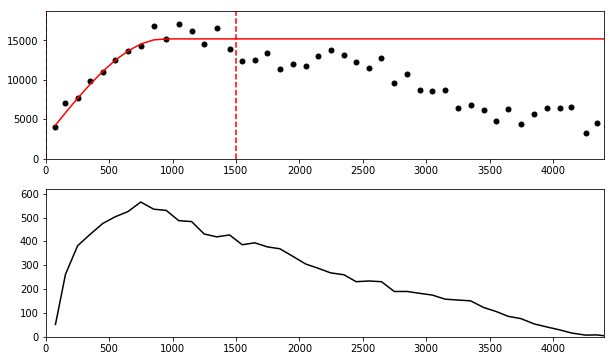

In [4]:
var_muese = VARIOGRAM(100, model=variogram_spherical)
var_muese.fit(gdf[['x', 'y']], gdf['lead'], fit_range=[0,1500])
PLT.figure(figsize=[10,6])
var_muese.plot()

In [77]:
ok_muese = kriging_ordinary(var_muese)
ok_muese.fit(gdf[['x', 'y']], gdf['lead'])

In [78]:
gdf.loc[0:1, ['x', 'y']].values

array([[181072., 333611.],
       [181025., 333558.]])

In [79]:
ok_muese.predict(gdf.loc[0:2, ['x', 'y']].values, use_nugget=False)

(array([299., 277., 199.]),
 array([-5.89655020e-14, -3.40506854e-14, -2.52387245e-14]),
 array([5.89655020e-14, 3.40506854e-14, 2.52387245e-14]))

In [80]:
gdf.loc[0:2, 'lead']

0    299.0
1    277.0
2    199.0
Name: lead, dtype: float64

In [76]:
class kriging_ordinary(object):

    def __init__(self, varigoram, debug=False):
        ## Local parameters ##
        self.variogram = varigoram
        self.debug = debug

    def fit(self, X, y, to=None, transparent=True, show=False):
        '''
        [DESCRIPTION]
            Store the data with KDTree or original data structure, and fit the variogram model with set parameters. 
        [INPUT]
            X          : array-like, input data with features, same data size with y.
            y          : array-like, input data with interesting value, same data size with X
        [OUTPUT]
            Null
        '''
        X = NP.atleast_1d(X)
        y = NP.atleast_1d(y)
        self.shape = X.shape
        self.ndim = X.ndim
        self.y = y
        self.X = cKDTree(X, copy_data=True)

    def predict(self, X, n_neighbor=None, radius=NP.inf, use_nugget=False, get_error=False):
        '''
        [DESCRIPTION]
           Calculate and predict interesting value with looping for all data, the method take long time but save memory
           Obtain the linear argibra terms
            | V_ij 1 || w_i | = | V_k |
            |  1   0 ||  u  |   |  1  |
                a    *   w    =    b
              w = a^-1 * b
              y = w_i * Y
            V_ij : semi-variance matrix within n neighors
            V_k  : semi-variance vector between interesting point and n neighbors
            w_i  : weights for linear combination
            u    : lagrainge multiplier
            Y    : true value of neighbors
            y    : predicted value of interesting point
        [INPUT]
            X          : array-like, input data with same number of fearture in training data
            n_neighbor : int,        number of neighbor w.r.t input data, while distance < searching radius (5)
            radius     : float,      searching radius w.r.t input data (inf)
            use_nugget : bool,       if use nugget to be diagonal of kriging matrix for prediction calculation (False)
            get_error  : bool,       if return error (False)
        [OUTPUT]
            1D/2D array(float)
            prediction : float, prdicted value via Kriging system
            error      : float, error of predicted value (only if get_error = True)
        '''
        X = NP.atleast_1d(X)
        if self.ndim == 1:
            if X.ndim < 2: X = X[:, NP.newaxis]
        else:
            X = NP.atleast_2d(X)     

        ## Find the neighbors 
        if n_neighbor is None: 
            n_neighbor = self.shape[0]
        neighbor_dst, neighbor_idx = self.X.query(X, k=n_neighbor, p=2 )

        ## Calculate prediction
        idxes = range(X.shape[0])
        lambda_y = NP.zeros(len(X))
        predict_y = NP.zeros(len(X))
        error_y = NP.zeros(len(X))
        for nd, ni, i in zip(neighbor_dst, neighbor_idx, idxes):
            ## select in searching radius
            ni = ni[nd < radius] # neighbors' index, while the distance < search radius
            nd = nd[nd < radius] # neighbors' distance, while the distance < search radius
            
            if len(ni) == 0: 
                continue 
            else: 
                n = len(ni)

            ## Initialization
            a = NP.zeros((n+1,n+1))  
            b = NP.ones((n+1,))

            ## Fill matrix a
            a[:n, :n] = self.variogram.predict(cdist(self.X.data[ni], self.X.data[ni], metric='euclidean'))
            a[:n, n] = 1
            a[n, :n] = 1

            ## Fill vector b
            b[:n] = self.variogram.predict(nd)
            #print(b)

            ## set self-varinace is zero if not using Nugget
            if not use_nugget:
                ## modify a
                NP.fill_diagonal(a, 0.)
                ## modify b
                zero_index = NP.where(NP.absolute(nd) == 0)
                if len(zero_index) > 0:
                    b[zero_index[0]] = 0.

            ## Get weights
            w = scipy.linalg.solve(a, b)
            #w = OPT.nnls(a, b)[0]

            if self.debug:
                print(">>      %d neighbors < %.2f distance : %s "%(len(ni), radius, str(nd)))
                print(">>      Fitted kriging matrix a: ")
                print(a)
                print(">>      Fitted semivarince between the location to %d neighbors b: "% n_neighbor)
                print(b)
                print(">>      Weights w: ")
                print(w)
                print(">>      Observe value y: ")
                print(self.y[ni])

            ## Fill results
            lambda_y[i] = w[n]
            predict_y[i] = w[:n].dot(self.y[ni])
            error_y[i] = w[:n].dot(b[:n])

        return predict_y, error_y, lambda_y